In [16]:
##Exercice 1
from math import *
from sympy import *
import numpy as np
    
def integ_romberg(f,a,b,epsilon):
    liste=[] ## initialisation de la liste
    inter=(b-a) ## Intervalle initiale
    liste.append([(inter/2)*(f(a)+f(b))])## On ajoute les intervalles à la liste
    for i in range(1,epsilon+1): ## boucle sur la précision
        inter = inter/2 ## on divise l'intervalle
        sum = 0
        for k in range(1,2**i ,2):
            sum = sum + f(a+k*inter) ## méthode des trapèzes
        row1 = [0.5*liste [i-1][0] + sum*inter]
        for j in range(1, i+1):
            row2 = row1[j-1] + (row1[j-1]+liste[i-1][j-1])/(4**j-1)
            row1.append(row2)
        liste.append(row1)
    return r

 
x=Symbol('x')
f = 3*x**2 + x**2 - 5 ## On définit la fonction f
print(integ_romberg(f,5,10,1e-6))



TypeError: 'Add' object is not callable

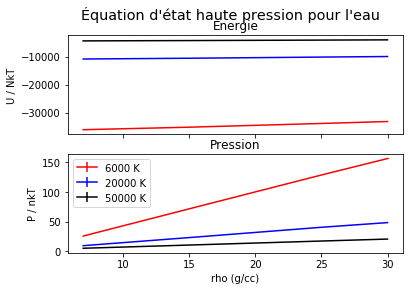

In [25]:
# Exercice 2
import numpy as N
import matplotlib.pyplot as P
import pytest

tolerance = 1e-8

class Simulation:

    def __init__(self, temp, dens, path):
        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]

    def __str__(self):
        return "Simulation at {:.0f} g/cc and {:.0f} K ; {:d} timesteps".format(self.dens, self.temp, len(self.pot))

    def thermo(self, skipSteps=0):
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:], 'rd--')
        axen.set_title("Internal energy (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:], 'rd--')
        axpress.set_title("Pressure (GPa)")
        axpress.set_xlabel("Timesteps")

        P.show()



def mimic_simulation(filename):
    with open(filename, 'w') as f:
        f.write("""Potential energy (Ha)	Kinetic Energy (Ha)	Pressure (GPa)
-668.2463567264        	0.7755612311   		9287.7370229824
-668.2118514558        	0.7755612311		9286.1395903265
-668.3119088218        	0.7755612311		9247.6604398856
-668.4762735176        	0.7755612311		9191.8574820856
-668.4762735176        	0.7755612311		9191.8574820856
""")


def test_Simulation_init():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 10, "equationEtat_simuTest.out")
    assert len(s.kin) == 5
    assert abs(s.kin[2] - 0.7755612311) < tolerance
    assert abs(s.pot[1] + 668.2118514558) < tolerance


def test_Simulation_str():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert str(s) == "Simulation at 20 g/cc and 10 K ; 5 timesteps"


def test_Simulation_thermo():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert abs(s.thermo()['T'] - 10) < tolerance
    assert abs(s.thermo()['rho'] - 20) < tolerance
    assert abs(s.thermo()['E'] + 667.56897157674) < tolerance
    assert abs(s.thermo()['P'] - 9241.0504034731) < tolerance
    assert abs(s.thermo(3)['E'] + 667.7007122865) < tolerance
    assert abs(s.thermo(3)['P'] - 9191.8574820856) < tolerance

# Main

if __name__ == '__main__':
    # Définitions
    a0 = 0.52918
    amu = 1.6605     
    k_B = 3.16681e-6  
    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu
    nsteps = 200
    temps = [6000, 20000, 50000]    # Température
    colors = {6000: 'r', 20000: 'b', 50000: 'k'}
    denss = [7, 15, 25, 30]  # Densité
    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
    eos = dict.fromkeys(keys, N.zeros(0))

    # Extraction des données du fichier décompréssé
    for t, rho in [(t, rho) for t in temps for rho in denss]:
        filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)
        s = Simulation(t, rho, filenm)
        for key in keys:
            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

    fig, (axen, axpress) = P.subplots(2, sharex=True)
    fig.suptitle("Équation d'état haute pression pour l'eau", size='x-large')
    axen.set_title("Energie")
    axen.set_ylabel("U / NkT")
    axpress.set_title("Pression")
    axpress.set_ylabel("P / nkT")
    axpress.set_xlabel("rho (g/cc)")
    for t in temps:
        sel = eos['T'] == t
        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
        axpress.errorbar(x=eos['rho'][sel],
                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                         fmt=colors[t] + '-',
                         label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()


In [29]:
# Exercice 3
from __future__ import division
import math
import numpy as N
import pytest
import matplotlib.pyplot as P

N.random.seed(255)
TAILLE = 20

class Ville(object):
    def __init__(self):
        self.destinations = N.array([]).reshape(-1, 2)

    def aleatoire(self, n=30):
        self.destinations = N.random.randint(TAILLE, size=(n, 2))

    def nb_trajets(self):
        ndest = len(self.destinations)
        if ndest > 2:
            return int(math.factorial(ndest - 1) / 2)
        elif ndest > 0:
            return 1
        else:
            return 0
    def distance(self, i, j):
        return N.abs(self.destinations[i] - self.destinations[j]).sum()

class Trajet(object):
    def __init__(self):
        self.destinations = N.array([]).reshape(-1, 2)

    def aleatoire(self, n=30):
        self.destinations = N.random.randint(TAILLE, size=(n, 2))
   

In [ ]:
## Sources

# Pour l'exercice1, aide de https://mathsci2.appstate.edu/~wmcb/Class/4310/ClassNotes131/Romberg_Program_Listings.pdf
# Pour l'exercice2 aide de https://informatique-python.readthedocs.io/fr/latest/Exercices/equationEtat.html
# Pour l'exercice3 aide de https://antoinevastel.com/algorithme/python/algorithmes%20g%C3%A9n%C3%A9tiques/2016/04/30/probleme-voyageur-commerce.html